# Predicting Tesla Stock Movements from Elon Musk's Tweets Using DistilBERT

## Project Description

As a data scientist at an investment company, I need to develop a tool that helps the company make smarter decisions about its investments in Tesla shares. We assume that the stock price of Tesla often changes a lot because of what Elon Musk tweets. So, we need a way to understand how his tweets might affect Tesla's stock.

My task is to train a model that predicts if the Tesla's stock price go up, down, or stay the same, based on Elon Musk's tweets.

To achive this I'll use the model "distilbert-base-uncased" from Hugging Face. <br>
"DistilBERT is a transformers model, smaller and faster than BERT, which was pretrained on the same corpus in a self-supervised fashion, using the BERT base model as a teacher. This means it was pretrained on the raw texts only, with no humans labelling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those texts using the BERT base model." [Source](https://huggingface.co/distilbert-base-uncased)

The project idea is to train this model with past data of Musk's tweets and how the stock responded.And see if the model can predict the stock price development based on new tweets.

## Data preparation

In [1]:
# set if runing local or usung colab
run_local = False

In [ ]:
# install vaderSentiment
if not run_local:
    !pip install vaderSentiment
    !pip install pip install alpha-vantage

In [3]:
# imports
import pandas as pd
import numpy as np
import json
import re
from itertools import product
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import metrics as ms
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# set random seed
random_seed = 1

### Data preparation Part 1/3
### In the following the tweet data will be prepared.

In [4]:
# load data
if run_local:
    # load csv file
    df_tweets = pd.read_csv('TweetsElonMusk.csv')
else:
    # authorize access to your google drive storage
    from google.colab import drive
    drive.mount('/content/drive')

    # load csv file
    df_tweets  = pd.read_csv('/content/drive/My Drive/SMA/TweetsElonMusk.csv')

Mounted at /content/drive


The dataset is from [Kaggle](https://www.kaggle.com/datasets/andradaolteanu/all-elon-musks-tweets/data), and contains tweets from Elon Musk between 2010-06-04 and 2021-04-17.

The dataset contains the following columns:

In [5]:
# columns
df_tweets.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [6]:
# show unique values of column 'language'
df_tweets['language'].unique()

array(['en', 'und', 'tl', 'de', 'uk', 'lt', 'et', 'sl', 'pt', 'ru', 'vi',
       'cs', 'in', 'nl', 'tr', 'es', 'ca', 'pl', 'lv', 'no', 'da', 'fr',
       'it', 'sv', 'ro', 'hi', 'ht', 'cy', 'ja', 'is', 'sr', 'hu', 'fi',
       'eu'], dtype=object)

Only use tweets with english language because Bert was trained on english language.

In [7]:
# drop rows with language different than 'en'
df_tweets = df_tweets[df_tweets['language'] == 'en']

In [8]:
# show unique values of column timezone
df_tweets['timezone'].unique()

array([300])

The dataset contains only the timezone 300. According to the dataset discription, that means -300 minutes from UTC and that's the Eastern Standard Time (EST) in North America.<br>
So in the following we need to remember that the time is EST to get related stock price information according to the time correct time zone.

Furthermore, only the columns 'date' and 'tweet' ara relevant for this project, so the other columns will be dropped.

In [9]:
# drop all columns except 'date',  and 'tweet'
df_tweets = df_tweets[['date', 'tweet']]

In [10]:
# get number of unique dates
df_tweets['date'].nunique()

2001

In [11]:
# get number of columns and rows
df_tweets.shape

(11138, 2)

The dataset contains days with several tweets. This project try to estimate the stock price of Tesla for the next day. So the tweets of one day will be combined to one string.

In [12]:
# combine all tweets from the same day into one row separated by space
df_tweets = df_tweets.groupby(['date'])['tweet'].apply(' '.join).reset_index()

In [13]:
# convert the date column to datetime type
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

### Data preparation Part 2/3
### In the following the stock price data will be prepared.

To train a model to estimate the stock price of Tesla, the stock price of Tesla is needed. Therefore the API of [Alpha Vantage](https://www.alphavantage.co/) is used.<br>
The API is free to use, but a registration to get an API key is required.

In [14]:
# read the API key from the json file
if run_local:
    with open('alpha_api_key.json', 'r') as file:
      api_key = json.load(file)['api_key'][0]['value']
else:
    # Authorize access to your google drive storage
    from google.colab import drive
    drive.mount('/content/drive')


    with open('/content/drive/My Drive/SMA/alpha_api_key.json', 'r') as file:
      api_key = json.load(file)['api_key'][0]['value']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# initialize the TimeSeries class with key and output format as pandas dataframe
ts = TimeSeries(key='api_key', output_format='pandas')

In [16]:
# get daily Tesla stock price data
df_stock , meta_data = ts.get_daily(symbol='TSLA', outputsize='full')

In [17]:
# set index date to a column
df_stock['date'] = df_stock.index

# remove index
df_stock.reset_index(drop=True, inplace=True)

In [18]:
# print the first five rows
df_stock.head()

,1. open,2. high,3. low,4. close,5. volume,date
0,236.86,240.1196,234.9001,237.49,92240035.0,2024-01-05
1,239.25,242.7000,237.7300,237.93,102629283.0,2024-01-04
2,244.98,245.6800,236.3200,238.45,121082599.0,2024-01-03
3,250.08,251.2500,244.4100,248.42,104654163.0,2024-01-02
4,255.10,255.1900,247.4300,248.48,100891578.0,2023-12-29


In [19]:
# get min and max date from the stock data
print(f'Min date: {df_stock.index.min()}')
print(f'Max date: {df_stock.index.max()}')

Min date: 0
Max date: 3403


The DataFrame df_stock contains the stock price of Tesla from 2010-06-04 to 2021-04-17.

In [20]:
meta_data

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'TSLA',
 '3. Last Refreshed': '2024-01-05',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

The stock price in df_stock are in the time zone US/Eastern. <br>
The US/Eastern timezone includes -5:00 and -4:00 hours from UTC and the tweets are in the time zone (EST) -5:00 hours from UTC.<br>
Because we consider the stock price of the next day a one hour difference is not relevant.

The dataset contains the open, high, low and close stock price for each day. <br>
To estimate the stock price of Tesla for the next day, the average stock price of Tesla for each day is calculated, with the following formula:

average stock price = (open + high + low + close) / 4

In [21]:
# calculate the average stock price for each day
df_stock['avg_price'] = (df_stock['1. open'] + df_stock['2. high'] + df_stock['3. low'] + df_stock['4. close']) / 4

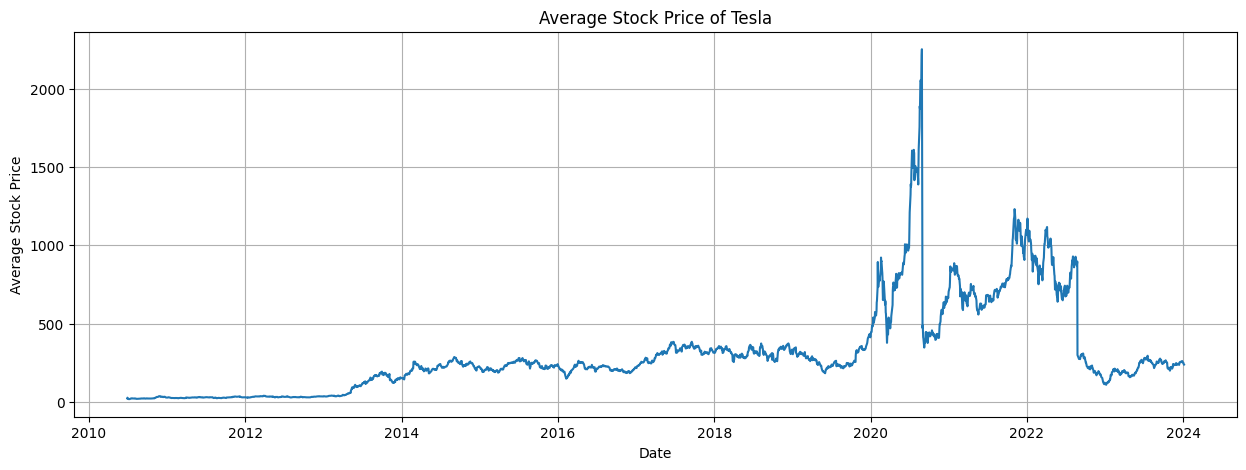

In [22]:
# plot the average stock price with column date_stock as x-axis
plt.figure(figsize=(15, 5))
plt.plot(df_stock['date'], df_stock['avg_price'])
plt.xlabel('Date')
plt.ylabel('Average Stock Price')
plt.title('Average Stock Price of Tesla')
plt.grid()
plt.show()


The plot shows that the average stock price of Tesla stayed quiet low form the beginning until 2013 and then increased until 2014. <br>
After that the stock price stayed the same until 2020. Between 2020 and 2023 the stock price had a high volatility.<br>
From 2023 till now the stock price went back to the level similar to the level before 2020.

In [23]:
# preate a new column price_development that indicates if the price increased, decreased or stayed the same compared to the previous day where the stock market was open
df_stock['price_development'] = df_stock['avg_price'].pct_change(-1)

In [24]:
# get the range of column price_development
df_stock['price_development'].min(), df_stock['price_development'].max()

(-0.7910718664052818, 0.22792384565783386)

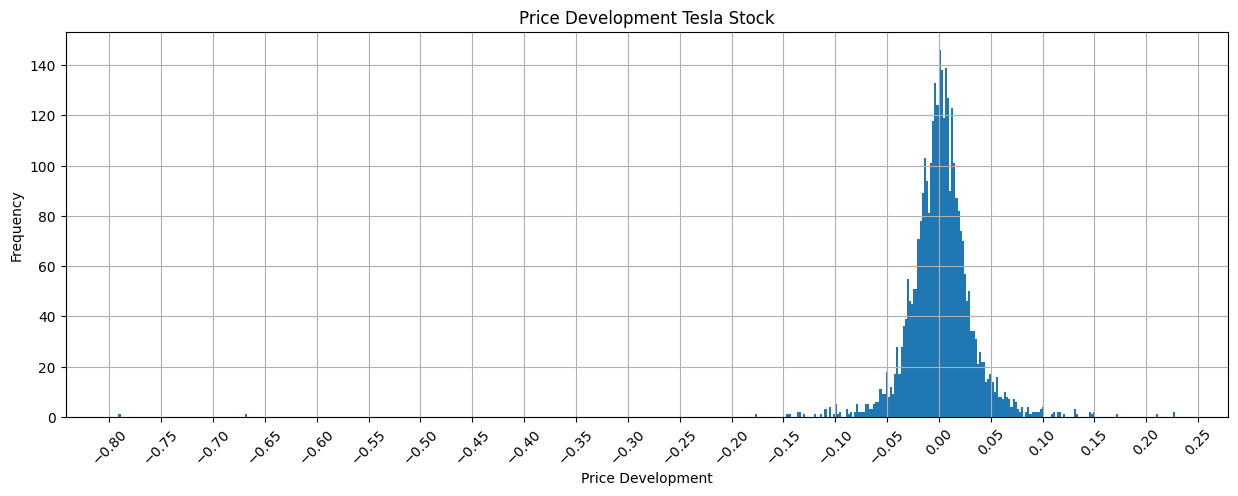

In [25]:
# plot a histogram of price_development with headline 'Price Development' and 1000 bins
plt.figure(figsize=(15, 5))
plt.title('Price Development Tesla Stock')
plt.xlabel('Price Development')
plt.ylabel('Frequency')
df_stock['price_development'].hist(bins=500)

# customize x-axis ticks
plt.xticks(rotation=45)  # Rotate ticks
plt.locator_params(axis='x', nbins=40)

plt.show()


The Price Development Plot from above show that the stock price development of Tesla is mostly between -0.05 and 0.05. <br> That means that the average stock price of Tesla changes mostly between -5% and 5% per day. <br>

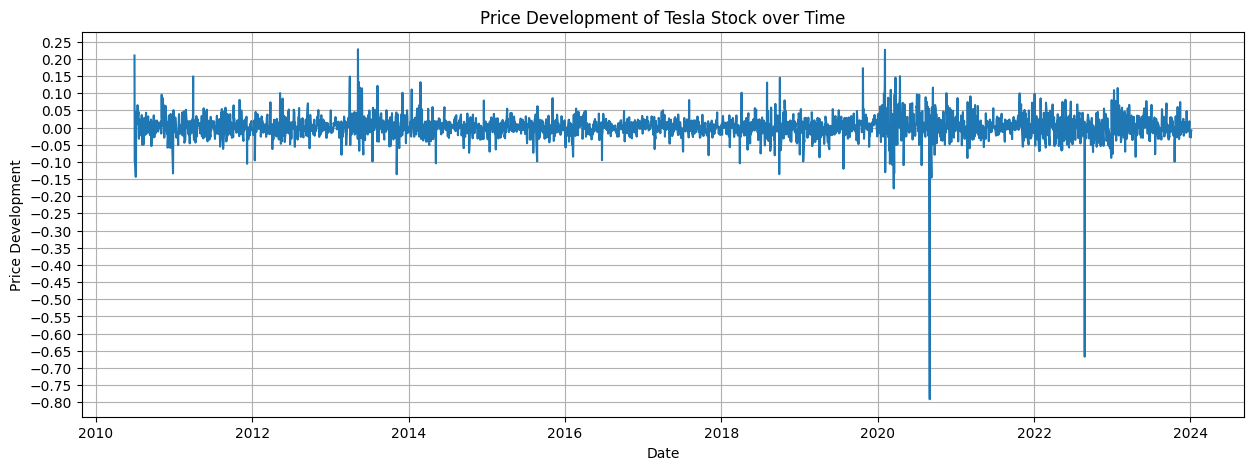

In [26]:
# plot the price_development with date_stock as x-axis
plt.figure(figsize=(15, 5))
plt.plot(df_stock['date'], df_stock['price_development'])
plt.xlabel('Date')
plt.ylabel('Price Development')
plt.title('Price Development of Tesla Stock over Time')
plt.grid()

# customize y-axis ticks
plt.locator_params(axis='y', nbins=30)
plt.show()

This plot again shows that the stock price of Tesla changes mostly between -5% and 5% per day. Additionally, the plot show where the stock had a high volatility. After 2020 and 2022 the are two high volatility phases.

In the following the stock price of Tesla will be classified into 3 classes: *0 for negative change*, *1 for no change* and *2 for positive change*.

In this Project the stock price of Tesla will be estimated for the next day and most changees are between -5% and 5% per day. So to catch the changes on a daily basis the following tresholds will be used:

<b>
Price development clssification:<br>

- price development < -0.01 -> class 0 (negative change bigger than -1%)

- -0.01 <= price development <= 0.01 -> class 1 (change smaller than +-1%)

- price development > 0.01 -> class 2 (positive change bigger than +1%)
</b>

In [27]:
# create a new column price_development_class that indicates if the price increased, decreased or stayed the same compared to the previous day where the stock market was open
x = 0.01
df_stock['price_development_class'] = np.where(df_stock['price_development'] < -x, 0, np.where(df_stock['price_development'] > x, 2, 1))

In [28]:
df_stock.head()

,1. open,2. high,3. low,4. close,5. volume,date,avg_price,price_development,price_development_class
0,236.86,240.1196,234.9001,237.49,92240035.0,2024-01-05,237.342425,-0.008605,1
1,239.25,242.7000,237.7300,237.93,102629283.0,2024-01-04,239.402500,-0.008100,1
2,244.98,245.6800,236.3200,238.45,121082599.0,2024-01-03,241.357500,-0.028899,0
3,250.08,251.2500,244.4100,248.42,104654163.0,2024-01-02,248.540000,-0.011966,0
4,255.10,255.1900,247.4300,248.48,100891578.0,2023-12-29,251.550000,-0.027525,0


### Data preparation Part 3/3
### Merg the tweets and the stock price development data

In [29]:
# merge the stock data and the tweets data
# use left on merge to keep all rows from the tweets data
df = pd.merge(df_tweets, df_stock, how='left', left_on='date', right_on='date')

In [30]:
# only keep the columns date, tweet and price_development_class
df = df[['date', 'tweet', 'price_development_class']]

The merged DataFrame "df" contains columns "tweets", "date" and "price development_class".

The latter shows if the average stock price of Tesla increased, decreased or stayed the same on the day after a tweet was posted.

In [31]:
# get number of rows with null values
df.isnull().sum()

date                         0
tweet                        0
price_development_class    601
dtype: int64

Since there are only stock prices for days where the stock market was open, there are null values for the tweets from weekends and holidays.

To handle this, tweets from days on which the market was closed could be append to a previous day where the market was open.  

To keep it simple the tweets from days on which the market was closed will be dropped.

In [32]:
# drop rows with null values and reset index
df = df.dropna().reset_index(drop=True)

In [33]:
# remove the links that appear in the tweets, because they are probably not relevant for the sentiment analysis

# define the regex pattern for URLs
url_pattern = r'https?://\S+'

# apply the lambda function to remove URLs
df['tweet'] = df['tweet'].apply(lambda x: re.sub(url_pattern, '', x))

In [34]:
# define a function to do data analysis (IDA)
def data_analysis(df,name):
    """
    Gives information about the dataframe for a quick overview.
    Args:
        df (pandas.DataFrame): The dataframe to be analysed.
        name (str): The name of the dataframe.
    Returns:
        None
    """
    print(f'Data analysis for {name}:\n')
    print(f'Shape: {df.shape}\n')

    # look at distribution of the price_development_class with percentage and absolute numbers
    print('Distribution of price_development_class in percentage:')
    print(df['price_development_class'].value_counts(normalize=True).sort_index()*100)
    print('\n')
    print('Distribution of price_development_class:')
    print(df['price_development_class'].value_counts().sort_index())

    column_name = []
    dtype = []
    count = []
    unique = []
    missing_values = []

    # create a list of column names, data types, number of non-null values, number of unique values and number of missing values
    for column in df.columns:
        column_name.append(column)
        dtype.append(df[column].dtype)
        count.append(len(df[column]))
        unique.append(len(df[column].unique()))
        missing_values.append(df[column].isna().sum())

    # create a dataframe consisting of the lists
    overview_values = pd.DataFrame({'column_name': column_name,'dtype': dtype,'count': count,'unique': unique,'missing_values': missing_values})
    display(overview_values)

    # sum up all the values in missing_values to get the total number of missing values
    missing_val  =  sum(missing_values) #sum of missing values
    print(f'Sum of missing values: {missing_val}\n')
    total_cells = np.prod(df.shape) # get total number of values in the dataframe
    print(f'Percentage of null values: {missing_val/total_cells*100:.2f}%\n')

    print('Head:')
    display(df.head())

    # get descriptive statistics for the numerical columns
    print('Discribe:')
    display(df.describe().round(2))
    print(' ') # do a linebreak

In [35]:
data_analysis(df,'Tweets with Stock Price Development')

Data analysis for Tweets with Stock Price Development:

Shape: (1400, 3)

Distribution of price_development_class in percentage:
0.0    27.285714
1.0    37.214286
2.0    35.500000
Name: price_development_class, dtype: float64


Distribution of price_development_class:
0.0    382
1.0    521
2.0    497
Name: price_development_class, dtype: int64


,column_name,dtype,count,unique,missing_values
0,date,datetime64[ns],1400,1400,0
1,tweet,object,1400,1400,0
2,price_development_class,float64,1400,3,0


Sum of missing values: 0

Percentage of null values: 0.00%

Head:


,date,tweet,price_development_class
0,2011-12-01,I made the volume on the Model S go to 11. ...,1.0
1,2011-12-21,"Yeah, this really is me, as my Mom @mayemusk w...",0.0
2,2011-12-22,Model S options are out! Performance in red an...,2.0
3,2011-12-28,If you ever wanted to know the *real* truth ab...,2.0
4,2011-12-29,@om Cool personal essay. It really resonated w...,1.0


Discribe:


,price_development_class
count,1400.00
mean,1.08
std,0.79
min,0.00
25%,0.00
50%,1.00
75%,2.00
max,2.00


The price_development_class 0 (negative change) is smallest with ~27%, followed by 2 (positive change) with ~35% and 1 (no change) with ~37%.

## Train a model to predict the stock price development

In the following a heuristics approach (Baseline) and the DistilBERT Model will be used to predict the stock price development.

### Splitting the data into train and test sets

In [36]:
# only use a subset of the data when runing localy, because of limited computing resources
if run_local:
  df = df[:20]

# set features
X = df['tweet']

# set target
y = df['price_development_class']

In [37]:
# create a single train-test split with stratification using the subset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1120,), (280,), (1120,), (280,))

In [38]:
# function that calculates the performance scores
def calculate_scores(y_true, y_pred, approach):
    """
    Calculates accuracy, recall, precision, and F1 score and returns the scores as a dictionary.
    Args:
        y_true (pandas.Series): The true labels.
        y_pred (pandas.Series): The predicted labels.
        approach (str): The name of the approach.
    Returns:
        dict: A dictionary containing the performance scores.
    """
    # calculate accuracy, recall, precision, and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # create a dictionary with the scores
    scores_dict = {'approach': approach, 'accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}

    return scores_dict

### Heuristic Model (Baseline)
In the following VADER Sentiment is used to predict the stock price development class.

In [39]:
# function to map compound score to a rating scale (0-3), because vaderSentiment returns a compound score between -1 and 1

def map_price_dev_pred(compound_score):
    if compound_score <= -1/3:
        return 0 # negative price development
    elif compound_score <= 1/3:
        return 1 # neutral price development
    else: # compound_score > 1/3
        return 2 # positive price development

In [40]:
# initialize the vaderSentiment analyzer
analyzer = SentimentIntensityAnalyzer()


# create an empty pandas series to store the sentiment ratings
sentiment_ratings_heuristic  = pd.Series(dtype='float64')

# iterate over the tweets in the test set
for index, row in X_test.items():
    # calculate the sentiment score using vaderSentiment
    sentiment_scores = analyzer.polarity_scores(row)

    # get the compound score
    compound_score = sentiment_scores['compound']

    # map the compound score to a rating scale from 1 to 5
    sentiment_rating = map_price_dev_pred(compound_score)

    # append the sentiment rating to the Series
    sentiment_ratings_heuristic.at[index] = sentiment_rating

In [41]:
# calculate the performance scores
scores = calculate_scores(y_test, sentiment_ratings_heuristic, 'Baseline')

In [42]:
# create a DataFrame with the scores
df_performance = pd.DataFrame(scores, index=[0])
df_performance

,approach,accuracy,recall,precision,f1
0,Baseline,0.389286,0.369217,0.369336,0.33549


The performance metrics of the VADER Sentiment analysis is similar to random guessing among the three price development classes (0 - decrease, 1 - no change, 2 - increase).
An accuracy of approximately 38% is only slightly better than the 33.33% accuracy expected from random guessing. The recall, precision, and F1 score, are around 33-37%, which is also similar to random guessing.

These results show that the approach with the VADER Sentiment analysis could not find a strong relationship between the stock price movements and the tweets.

This baseline model serves as a starting point, indicating that more advanced approaches are necessary for effective prediction.

### Train DistilBERT

In [ ]:
# load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [44]:
# Define a class for the dataset
class TweetDataset(Dataset):
    """
    A custom PyTorch Dataset for tweets.
    This dataset is used for processing and preparing tweet data for sentiment analysis using a DistilBERT model.
    """

    def __init__(self, tweets, labels, tokenizer, max_len):
        """
        Initializes the dataset with tweets, labels, a tokenizer, and a maximum sequence length.

        Args:
            tweets (list or pandas.Series): A list or pandas series containing tweet texts.
            labels (list or pandas.Series): A list or pandas series containing labels for the tweets.
            tokenizer: Tokenizer object from the transformers library for text tokenization.
            max_len (int): Maximum length of the tokenized tweet sequence.
        """
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        """
        Returns the length of the dataset.
        """
        return len(self.tweets)

    def __getitem__(self, idx):
        """
        Retrieves a single processed item (tweet) from the dataset.

        Args:
            idx (int): The index of the item to be retrieved.

        Returns:
            dict: A dictionary containing the processed text data and labels.
        """
        # handle different types of data structures (pandas.Series or list)
        tweet = str(self.tweets.iloc[idx]) if hasattr(self.tweets, 'iloc') else str(self.tweets[idx]) # convert tweet to string
        label = self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx] # get label

        # encode the tweet text for the model input
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,  # add '[CLS]' and '[SEP]'
            max_length=self.max_len,  # truncate/pad tweets to a max length
            return_token_type_ids=False,
            padding='max_length',  # pad shorter tweets to the max length
            truncation=True,
            return_attention_mask=True,  # return attention mask
            return_tensors='pt',  # return PyTorch tensors
        )

        # return a dictionary with the encoded data and labels
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [45]:
# deine a function validate a model
def validate(model, dataloader, device):
    """
    Validates the given model using the provided dataloader.

    Args:
        model: The model to be validated.
        dataloader: DataLoader containing the validation dataset.
        device: The device (CPU or GPU) to perform the validation on.

    Returns:
        float: The accuracy of the model on the validation set.
    """
    # set the model to evaluation mode. this will turn off specific layers like dropout
    model.eval()

    # lists to store the true labels and model's predictions
    predictions, true_labels = [], []

    # disable gradient calculations as they are not needed for validation
    # this reduces memory usage and speeds up computations
    with torch.no_grad():
        # iterate over the data in the dataloader
        for batch in dataloader:
            # move the input IDs and attention masks to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass: compute the outputs of the model
            outputs = model(input_ids, attention_mask=attention_mask)

            # extract logits (model outputs prior to activation function)
            logits = outputs.logits

            # convert the logits to probabilities and get the predicted class (highest probability)
            predictions.extend(torch.argmax(logits, dim=1).tolist())

            # store the true labels of the batch
            true_labels.extend(labels.tolist())

    # calculate and return the accuracy of the model on the test set
    return accuracy_score(true_labels, predictions)


In [46]:
# set the hyperparameters for grid search
param_grid = {
    'learning_rate': [1e-5, 3e-5, 5e-5],
    'batch_size': [16, 32],
    'epochs': [2, 3, 4]
}

In [47]:
# prepare the dataset
MAX_LEN = 125 # max length of the tokenized tweet sequence
tweets = df['tweet'].tolist() # get the tweets as a list
labels = df['price_development_class'].tolist() # get the labels as a list

# create train and test datasets
train_dataset = TweetDataset(X_train, y_train, tokenizer, MAX_LEN) # create the training dataset with the X_train and y_train
test_dataset = TweetDataset(X_test, y_test, tokenizer, MAX_LEN) # create the test dataset with the X_test and y_test


In [48]:
# function to train the model
def train(model, dataloader, optimizer, device):
    """
    Trains the model for one epoch.

    Args:
        model: The model to be trained.
        dataloader: DataLoader containing the training dataset.
        optimizer: The optimizer used for updating the model parameters.
        device: The device (CPU or GPU) to perform the training on.

    Returns:
        float: The average loss of the model over the training dataset.
    """
    # set the model to training mode. this enables layers like dropout layers that work differently during training
    model.train()

    # initialize total loss
    total_loss = 0

    # iterate over each batch in the dataloader
    for batch in dataloader:
        # move the input and labels to the specified device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # clear previous gradients before performing a backward pass
        model.zero_grad()

        # forward pass: compute the model's output on the input data
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # extract the loss from the model's output
        loss = outputs.loss

        # accumulate the loss.
        total_loss += loss.item()

        # perform a backward pass to calculate gradients
        loss.backward()

        # update model parameters
        optimizer.step()

    # calculate and return the average loss over all batches in the dataloader
    return total_loss / len(dataloader)


In [ ]:
# initialize the best accuracy, best parameters, and best model
best_accuracy = 0
best_params = {}
best_model = None

# set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# iterate over all combinations of hyperparameters defined in param_grid (grid search)
for params in product(*param_grid.values()):
    # unpack the current combination of hyperparameters
    learning_rate, batch_size, epochs = params

    # initialize the model with the pre-trained DistilBert model and set the number of output labels
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

    # move the model to the specified device (GPU or CPU)
    model.to(device)

    # initialize the optimizer with the model parameters and the current learning rate
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # create DataLoaders for training and test datasets with the current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # variable to accumulate test accuracy across all epochs
    total_test_accuracy = 0

    # training and test loop for the current set of hyperparameters
    for epoch in range(epochs):
        # train the model for one epoch and get the training loss
        train_loss = train(model, train_loader, optimizer, device)
        # validate the model and get the test accuracy
        test_accuracy = validate(model, test_loader, device)
        # add the test accuracy to the total test accuracy
        total_test_accuracy += test_accuracy

    # calculate the average test accuracy over all epochs
    avg_test_accuracy = total_test_accuracy / epochs

    # if the current model's average test accuracy is the best so far, update the best accuracy and save the model parameters
    if avg_test_accuracy > best_accuracy:
        best_accuracy = avg_test_accuracy
        best_params = {'learning_rate': learning_rate, 'batch_size': batch_size, 'epochs': epochs}
        best_model = model

In [50]:
print(f"Best Parameters found by grid search: {best_params}")

Best Parameters found by grid search: {'learning_rate': 5e-05, 'batch_size': 32, 'epochs': 2}


In [51]:
# tokenize and format the test set
test_dataset = TweetDataset(X_test, y_test, tokenizer, MAX_LEN)
# create batches from the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

# function to evaluate the model on the test set
def evaluate(model, dataloader, device):
    """
    Evaluates the model performance on the given dataset.

    Args:
        model: The trained model to evaluate.
        dataloader: DataLoader that provides batches from the test dataset.
        device: The device (GPU or CPU) to perform the evaluation on.

    Returns:
        (list, list): The first list contains true labels, and the second list contains the model's predictions.
    """
    # set the model to evaluation mode
    model.eval()

    # lists to store the true labels and the predictions made by the model
    predictions, true_labels = [], []

    # disables gradient calculations to save memory and computations as they are not needed for evaluation
    with torch.no_grad():
        # iterate over each batch in the dataloader
        for batch in dataloader:
            # transfer the batch data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # forward pass: Compute the outputs of the model
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # The raw model outputs before activation

            # convert these logits to actual predictions (class labels with highest probability)
            preds = torch.argmax(logits, dim=1).tolist()
            # extend the predictions and true labels lists with the results from this batch
            predictions.extend(preds)
            true_labels.extend(batch['labels'].tolist())

    # return the true labels and predictions
    return true_labels, predictions

# evaluate the best model on the test set and get the true labels and predictions
true_labels, predictions = evaluate(best_model, test_loader, device)



In [52]:
# save model state dictionary form the best model
if run_local:
    # save local
    torch.save(best_model.state_dict(), 'tesla_stock_pred.pth')
else:
    # save to Google Drive
    torch.save(best_model.state_dict(), 'drive/MyDrive/SMA/tesla_stock_pred.pth')

In [ ]:
# convert lists to pandas.Series
y_true_series = pd.Series(true_labels)
y_pred_series = pd.Series(predictions)

# calculate the performance scores
scores = calculate_scores(y_true_series, y_pred_series, 'distilbert-base-uncased')

# concatenate with the DataFrame containing the scores
df_performance = pd.concat([df_performance, pd.DataFrame([scores])], ignore_index=True)

In [54]:
# print the table with the performance scores
df_performance

,approach,accuracy,recall,precision,f1
0,Baseline,0.389286,0.369217,0.369336,0.33549
1,distilbert-base-uncased,0.400000,0.361667,0.276580,0.27515


**DistilBERT Model Performance:**

- Accuracy: 40.0% - This indicates that the DistilBERT model correctly predicts the class 40% of the time. While slightly higher than the baseline, this is still a relatively low accuracy, suggesting the model struggles to generalize well to the test data.
- Recall: 36.2% - The model's ability to correctly identify all relevant instances in each class is fairly low. This means it misses quite a few true positives.
- Precision: 27.7% - This is significantly lower than the baseline, indicating that out of all the instances the model predicts as positive, fewer of these predictions are actually correct.
-  F1 Score: 27.5% - The F1 score, which balances precision and recall, is also low, indicating that the model doesn't balance these two metrics effectively.


The baseline model, while slightly less accurate in terms of overall accuracy, outperforms the DistilBERT model in precision, recall, and F1 score. This suggests that despite the advanced capabilities of DistilBERT, the model configuration, training process, or data representation might not be optimal for this specific task.


Get a better understanding of the model's performance by looking at the confusion matrix:

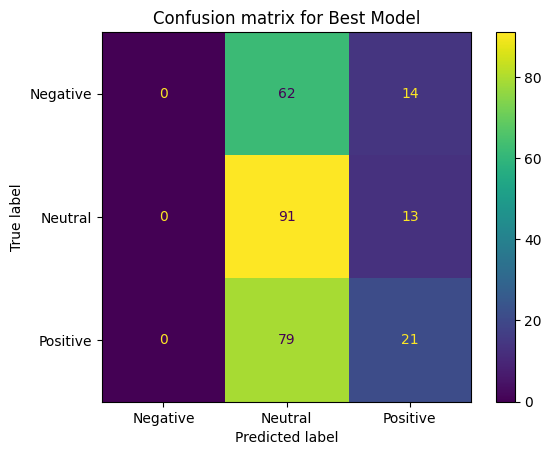

In [55]:
# look at the confusion matrix
ms.ConfusionMatrixDisplay.from_predictions(y_true_series,y_pred_series)
plt.title('Confusion matrix for Best Model')
plt.xticks(ticks=[0,1,2],labels=['Negative','Neutral','Positive']) # set x-axis ticks and labels
plt.yticks(ticks=[0,1,2],labels=['Negative','Neutral','Positive']) # set y-axis ticks and labels
plt.show()


- Negative Class: The model did not correctly predict any negative instances. All negative instances were misclassified as neutral or positive.
- Neutral Class: The model performed best on this class, correctly classifying 91 instances as neutral, but still misclassifying 13 as positive.
- Positive Class: The model predicted 21 instances correctly as positive but misclassified 79 as neutral.

This confusion matrix reveals that the model struggles particularly with the negative class, never predicting it correctly. It also tends to confuse positive with neutral. The model's best performance is in identifying neutral tweets, but even here, there is room for improvement.

### Overall analysis to imiprove the DistilBERT Model:

The current performance of the DistilBERT model for predicting stock price movements based on Elon Musk's tweets is not yet optimal. To enhance the model's effectiveness, several strategies could be considered:

- **Adjusting time periods between tweets and stock prices:** Instead of using the next day's stock price, experimenting with different time shifts, like the stock price after 2 days or even the next 5 hours, might yield more accurate correlations.

- **Modifying price development classification thresholds:** Optimize the thresholds for classifying stock price changes could lead to more precise predictions.

- **Data preparation adjustments:** Rather than discarding tweets from days when the stock market was closed, these tweets could be attributed to the preceding market day. This might capture more relevant sentiment data.

- **Expanded grid search:** Including more hyperparameters in the grid search could uncover a more effective combination for the model.

- **Enriching the training data:** Incorporating additional data sources, such as news articles about Tesla or Elon Musk, might provide a more comprehensive view for the model to learn from.

- **Considering intra-day stock price variations:** Currently, only average daily stock prices are used. However, Tesla's stock can fluctuate significantly within a day. Incorporating intra-day price movements could enhance prediction accuracy.

- **Exploring alternative models:** Given that DistilBERT underperformed compared to the baseline, exploring other models could be beneficial. Different architectures or more advanced NLP models might be better suited to this specific task.

Implementing these strategies could significantly improve the model's performance, making it a more reliable tool for predicting stock price movements based on influential social media content.

## Conclution

In my role as a Data Scientist at an investment company, I started on a project to create a tool predicting Tesla's stock movements based on Elon Musk's tweets. Using the "distilbert-base-uncased" model from Hugging Face, I aimed to analyze the correlation between Musk's tweets and Tesla's stock price changes.

The model was trained on historical tweet data and stock responses, focusing on whether the stock would rise, fall, or stay constant after each tweet. While the DistilBERT model showed some promise, it also highlighted areas for improvement and further exploration, such as fine-tuning the data processing and possibly considering alternative models.

This project underscored the potential of machine learning in financial decision-making, but also the importance of careful model selection and evaluation.

**Note**: This project was created with the help of ChatGPT and the GitHub Copilot.